In [1]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:

import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import numpy as np
from sklearn.model_selection import train_test_split




In [3]:
#import opendatasets as od

#od.download("https://www.kaggle.com/datasets/mohamedjafirashraf/fuel-consumption-co2")


In [4]:
df=pd.read_csv('FuelConsumptionCo2.csv')

In [5]:
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MODELYEAR                 1067 non-null   int64  
 1   MAKE                      1067 non-null   object 
 2   MODEL                     1067 non-null   object 
 3   VEHICLECLASS              1067 non-null   object 
 4   ENGINESIZE                1067 non-null   float64
 5   CYLINDERS                 1067 non-null   int64  
 6   TRANSMISSION              1067 non-null   object 
 7   FUELTYPE                  1067 non-null   object 
 8   FUELCONSUMPTION_CITY      1067 non-null   float64
 9   FUELCONSUMPTION_HWY       1067 non-null   float64
 10  FUELCONSUMPTION_COMB      1067 non-null   float64
 11  FUELCONSUMPTION_COMB_MPG  1067 non-null   int64  
 12  CO2EMISSIONS              1067 non-null   int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 108.5+ KB


In [7]:
df['FUELTYPE'].value_counts()

FUELTYPE
X    514
Z    434
E     92
D     27
Name: count, dtype: int64

<Axes: xlabel='FUELCONSUMPTION_COMB', ylabel='CO2EMISSIONS'>

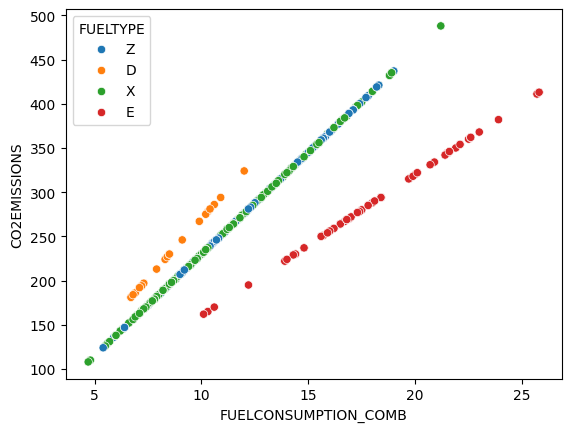

In [8]:
sns.scatterplot(df, x='FUELCONSUMPTION_COMB', y='CO2EMISSIONS',  hue='FUELTYPE')


In [9]:
class LR_hue:
    def __init__(self):
        self.fitted=False
        
    def fit(self, X, y, hue):
        self.hue=hue
        self.hue_features=[]
        self.hue_features=X[hue].unique()
        self.dict_lr={}
        yre=[]
        yhatre=[]
        for hue_feature in self.hue_features:
            xh=X[X[hue]==hue_feature].drop(hue, axis=1).to_numpy()
            yh=y[X[hue]==hue_feature].to_numpy()
            yre=np.concatenate((yre, yh))
            self.dict_lr[hue_feature]=LinearRegression()
            self.dict_lr[hue_feature].fit(xh, yh)
            yhat=self.dict_lr[hue_feature].predict(xh)
            yhatre=np.concatenate((yhatre, yhat))
            
        print('training accuracy score:', metrics.mean_squared_error(yre,yhatre))
        print('training r2_score:', metrics.r2_score(yre,yhatre))
        print('training mean_squared_error:', metrics.mean_squared_error(yre,yhatre))   
        
        self.fitted=True    
        #return self.dict_lr
        
    def check_fitted(self):
        if not self.fitted:
            raise ValueError("NotFittedError")
            
    def predict(self, X):
        self.check_fitted()
        hue=self.hue
        y=X.copy()[[]]       #create empty y to store predictions keeping the indexes from X
        y['yhat']=np.nan
        for hue_feature in self.hue_features:
            xh=X[X[hue]==hue_feature].drop(hue, axis=1)
            pr=self.dict_lr[hue_feature].predict(xh.to_numpy())
            pr=pd.DataFrame(pr, columns=['yhat'], index=xh.index) # store predictions with original x.index used
            y.update(pr) #only update the values in y where indexes from pr matches
        return y['yhat']
    
    def get_params(self):
        self.check_fitted()
        df_params=pd.DataFrame(columns=['Variable','params'])
        for hue_feature in self.hue_features:
            df_params.loc[len(df_params.index)]=[hue_feature, self.dict_lr[hue_feature].get_params()]
        return df_params
    
    def coef_(self):
        self.check_fitted()
        df_params=pd.DataFrame(columns=['Variable','coef_'])
        for hue_feature in self.hue_features:
            df_params.loc[len(df_params.index)]=[hue_feature, self.dict_lr[hue_feature].coef_]
        return df_params        
    
    def intercept_(self):
        self.check_fitted()
        df_params=pd.DataFrame(columns=['Variable','coef_'])
        for hue_feature in self.hue_features:
            df_params.loc[len(df_params.index)]=[hue_feature, self.dict_lr[hue_feature].intercept_]
        return df_params
    
    def scores(self,X,y):
        self.check_fitted()
        y=y.to_frame()
        hue=self.hue
        yhat=self.predict(X).to_frame()
        df_params=pd.DataFrame(columns=[hue,'Accuracy', 'R2', 'MSE', 'MAE'])
        for hue_feature in self.hue_features:
            yhath=yhat[X[hue]==hue_feature]
            yh=y[X[hue]==hue_feature]
            df_params.loc[len(df_params.index)]=[hue_feature, metrics.mean_squared_error(yh,yhath), metrics.r2_score(yh,yhath), metrics.mean_squared_error(yh,yhath) ,metrics.mean_absolute_error(yh,yhath)]
        df_params.loc[len(df_params.index)]=['Total', metrics.mean_squared_error(y,yhat), metrics.r2_score(y,yhat), metrics.mean_squared_error(y,yhat) ,metrics.mean_absolute_error(y,yhat)]
        return df_params
        
        

In [10]:
lr=LR_hue()

In [11]:
X=df[['ENGINESIZE', 'CYLINDERS' ,'FUELTYPE', 'FUELCONSUMPTION_CITY','FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB' ,'FUELCONSUMPTION_COMB_MPG']]
y=df['CO2EMISSIONS']


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=0.2, random_state=2)

In [13]:
lr.fit(X_train,Y_train,'FUELTYPE')

training accuracy score: 0.0807801211975291
training r2_score: 0.9999790538422615
training mean_squared_error: 0.0807801211975291


In [14]:
y_hat=lr.predict(X_test)

print('Test accuracy score:', metrics.mean_squared_error(Y_test,y_hat))
print('Test r2_score:', metrics.r2_score(Y_test,y_hat))
print('Test mean_squared_error:', metrics.mean_squared_error(Y_test,y_hat))

Test accuracy score: 0.09535103934645543
Test r2_score: 0.9999794088079672
Test mean_squared_error: 0.09535103934645543


In [15]:
lr.scores(X_test,Y_test)

,FUELTYPE,Accuracy,R2,MSE,MAE
0,E,0.068135,0.999983,0.068135,0.223066
1,Z,0.086343,0.999980,0.086343,0.254018
2,X,0.099788,0.999978,0.099788,0.270386
3,D,0.201933,0.999927,0.201933,0.392293
4,Total,0.095351,0.999979,0.095351,0.264394


In [16]:
lr.coef_()

,Variable,coef_
0,E,"[0.3182812507831873, -0.3382745877401261, -0.0..."
1,Z,"[-0.04030147054079023, 0.02139321295289065, -0..."
2,X,"[0.01091853818201069, -0.009003584662975683, 0..."
3,D,"[-2.8626608472009623, 1.2013025137407611, -0.6..."


In [17]:
lr.intercept_()

,Variable,coef_
0,E,0.117799
1,Z,0.763176
2,X,-0.215656
3,D,16.558794
